In [3]:
import os
os.chdir('../../../../src')

In [4]:
from data import PolygonSentenceReader, Polygon
from modules import NLLLoss, ELBOLoss
from neural_process.models.np import CNP, LNP
from neural_process.models.attnnp import AttnCNP, AttnLNP
from utils import plot_polygon

import datetime
import random
import torch
import torch.nn as nn
from torch.distributions.kl import kl_divergence

In [19]:
TRAINING_ITERATIONS = int(2e5)
PLOT_AFTER = int(2e4)
BATCH_SIZE = 64
MAX_CONTEXT_POINTS = 10
MIN_SIDES = 4
MAX_SIDES = 4
x_size = 4 + 3 * MAX_SIDES
y_size = MAX_SIDES
torch.manual_seed(0)

criterion = ELBOLoss()

# Instantiate a polygon generator.
# (For example, polygons with between 3 and 8 sides.)
polygon_generator_train = PolygonSentenceReader(
    batch_size=BATCH_SIZE,
    max_num_context=MAX_CONTEXT_POINTS,
    max_seq_len=x_size,
    min_num_sides=MIN_SIDES,
    max_num_sides=MAX_SIDES,
    center=(5, 5),
    radius=3,
    testing=False,
)

polygon_generator_test = PolygonSentenceReader(
    batch_size=100,
    max_num_context=MAX_CONTEXT_POINTS,
    max_seq_len=x_size,
    min_num_sides=MIN_SIDES,
    max_num_sides=MAX_SIDES,
    center=(5, 5),
    radius=3,
    testing=True,
)

model = LNP(x_dim=x_size, y_dim=y_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=TRAINING_ITERATIONS, eta_min=1e-6
)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
device = next(model.parameters()).device

# Training

In [23]:
# ----------------------
# Training Loop
# ----------------------
for it in range(TRAINING_ITERATIONS + 1):
    # Generate a batch of polygon completion tasks.
    (
        context_x,
        context_y,
        target_x,
        target_y,
        tokens,
        true_poly,
        max_seq_len,
        num_context,
    ) = polygon_generator_train.generate_polygon_batch_few_shot_completion_task()

    context_x = context_x.to(device)
    context_y = context_y.to(device)
    target_x = target_x.to(device)
    target_y = target_y[:, :, :y_size].to(device)

    optimizer.zero_grad()
    # Forward pass: the NP model expects context_x, context_y, target_x, target_y.
    dist, z, q_zc, q_zct = model(context_x, context_y, target_x, target_y)
    loss = criterion(dist, q_zct, q_zc, target_y)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if it % 1000 == 0:
        print("Iteration: {}, train loss: {}".format(it, loss.item()))

    # ----------------------
    # Evaluation and Plotting
    # ----------------------
    if it % PLOT_AFTER == 0:
        # For plotting, we generate a single polygon sample.
        (
            context_x_eval,
            context_y_eval,
            target_x_eval,
            target_y_eval,
            tokens_eval,
            true_poly_eval,
            max_seq_len_eval,
            num_context_eval,
        ) = polygon_generator_test.generate_polygon_batch_few_shot_completion_task()

        context_x_eval = context_x_eval.to(device)
        context_y_eval = context_y_eval.to(device)
        target_x_eval = target_x_eval.to(device)
        target_y_eval = target_y_eval[:, :, :y_size].to(device)

        # Forward pass through the model.
        test_dist, test_z, test_q_zc, test_q_zct = model(
            context_x_eval, context_y_eval, target_x_eval, target_y_eval
        )
        loss = criterion(test_dist, test_q_zct, test_q_zc, target_y_eval)

        print(
            "{}, Iteration: {}, Test Loss: {}".format(
                datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                it,
                loss.item(),
            )
        )

        # Get NP predictions on target tokens (taking the mean of the predictive distribution).
        pred_target = test_dist.mean  # shape: [n_z, batch, n_target, y_dim]

        # For simplicity, we average over latent samples and batch dimension.
        pred_target_avg = pred_target.mean(0).squeeze(1)  # shape: [n_target, y_dim]

        # print("pred_target_avg shape: ", pred_target_avg.shape)
        pred_target_avg = pred_target_avg[0]
        true_polygon = true_poly_eval[0]
        true_polygon_tokenised = true_polygon.to_tokenised()
        # print("pred_target_avg shape after squeeze: ", pred_target_avg.shape)

        print("True Polygon: ", true_polygon)
        print("True Polygon Angles: ", true_polygon.angles)
        print("Predicted Polygon Angles: ", pred_target_avg.tolist())

Iteration: 0, train loss: 92004.453125
2025-05-02 17:36:08, Iteration: 0, Test Loss: 71714.28125
True Polygon:  Polygon(n=4, vertices=[(7.91, 5.72), (4.4, 7.94), (4.52, 2.04), (7.2, 2.96)], lengths=[4.153131348753613, 5.901220212803451, 2.8335137197479745, 2.8498596456667826], angles=[107.88614226147631, 56.522344135681244, 72.21867254867969, 123.37284105416278])
True Polygon Angles:  [107.88614226147631, 56.522344135681244, 72.21867254867969, 123.37284105416278]
Predicted Polygon Angles:  [59.97529602050781, 61.028411865234375, 68.20648956298828, 7.379937648773193]
Iteration: 1000, train loss: 67780.3046875
Iteration: 2000, train loss: 18880.060546875
Iteration: 3000, train loss: 58583.4375
Iteration: 4000, train loss: 25915.177734375
Iteration: 5000, train loss: 38653.94921875
Iteration: 6000, train loss: 19226.130859375
Iteration: 7000, train loss: 18421.48046875
Iteration: 8000, train loss: 11929.603515625
Iteration: 9000, train loss: 13455.94140625
Iteration: 10000, train loss: 10

In [24]:
torch.save(model.state_dict(), "../models/polygon/np/" + model.__class__.__name__ + "_angles_completion_task_squares_only.pt")

In [25]:
model.load_state_dict(
    torch.load("../models/polygon/np/" + model.__class__.__name__ + "_angles_completion_task_squares_only.pt", map_location=device)
)
model.eval()
model.to(device)

LNP(
  (decoder): MLP(
    (activation): ReLU()
    (dropout): Dropout(p=0, inplace=False)
    (to_hidden): Linear(in_features=144, out_features=128, bias=True)
    (linears): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
    )
    (out): Linear(in_features=128, out_features=8, bias=True)
  )
  (encoder): MLP(
    (activation): ReLU()
    (dropout): Dropout(p=0, inplace=False)
    (to_hidden): Linear(in_features=20, out_features=128, bias=True)
    (linears): ModuleList(
      (0-1): 2 x Linear(in_features=128, out_features=128, bias=True)
    )
    (out): Linear(in_features=128, out_features=128, bias=True)
  )
  (latent_encoder): MLP(
    (activation): ReLU()
    (dropout): Dropout(p=0, inplace=False)
    (to_hidden): Linear(in_features=128, out_features=128, bias=True)
    (linears): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
    )
    (out): Linear(in_features=128, out_features=256, bias=True)
  )
  (reshape_r_z): Linea

# LNP trained on Triangular Polygons with 1-10 Context Points

# Evaluation

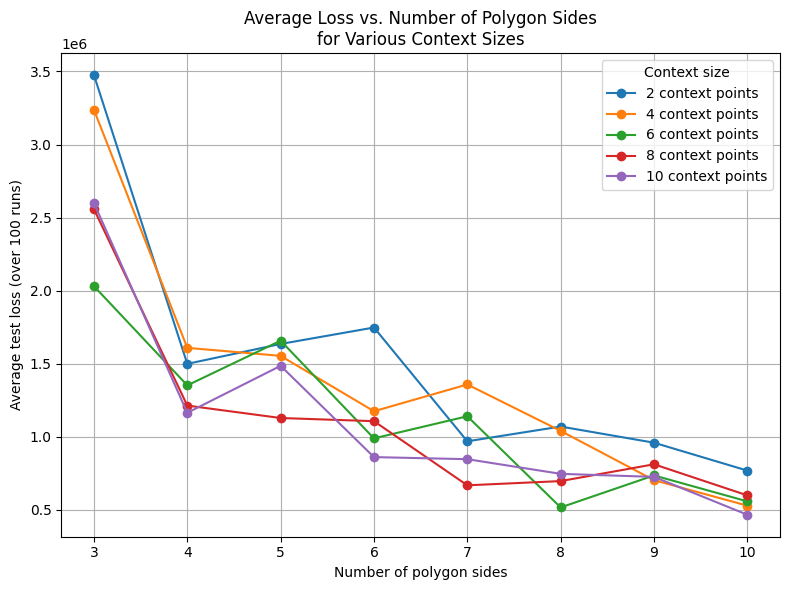

In [26]:
import matplotlib.pyplot as plt
import numpy as np

BATCH_SIZE = 100
sides_list = list(range(3, 11))
context_points_list = [2, 4, 6, 8, 10]
avg_losses = []
criterion = NLLLoss()

plt.figure(figsize=(8, 6))

for num_context in context_points_list:
    avg_losses = []
    for sides in sides_list:
        losses = []
        polygon_generator_test = PolygonSentenceReader(
            batch_size=BATCH_SIZE,
            max_num_context=num_context,
            max_seq_len=x_size,
            min_num_sides=sides,
            max_num_sides=sides,
            center=(5, 5),
            radius=3,
            testing=True,
        )
        (
            context_x_eval,
            context_y_eval,
            target_x_eval,
            target_y_eval,
            *_,
        ) = polygon_generator_test.generate_polygon_batch_few_shot_completion_task(num_context)

        context_x_eval = context_x_eval.to(device)
        context_y_eval = context_y_eval.to(device)
        target_x_eval = target_x_eval.to(device)
        target_y_eval = target_y_eval.to(device)

        test_dist, _, _, _ = model(
            context_x_eval, context_y_eval, target_x_eval, target_y_eval
        )
        loss = criterion(test_dist, target_y_eval)
        losses.append(loss.item())

        avg_losses.append(np.mean(losses))

    plt.plot(sides_list,
             avg_losses,
             marker='o',
             label=f'{num_context} context{" point" if num_context==1 else " points"}')

plt.xlabel("Number of polygon sides")
plt.ylabel("Average test loss (over 100 runs)")
plt.title("Average Loss vs. Number of Polygon Sides\nfor Various Context Sizes")
plt.xticks(sides_list)
plt.grid(True)
plt.legend(title="Context size")
plt.tight_layout()
plt.show()

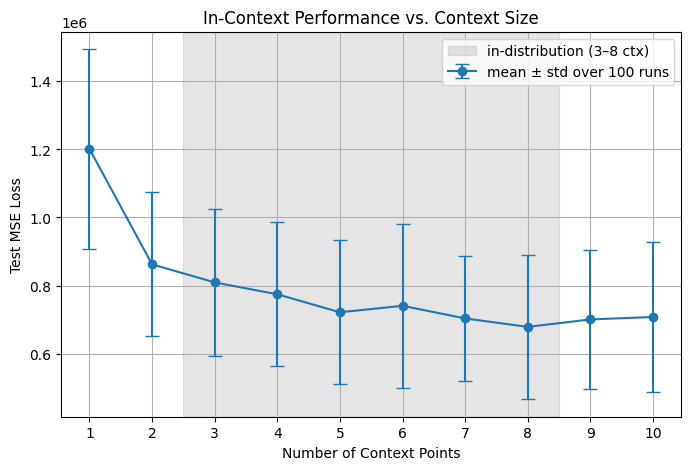

In [32]:
import numpy as np
import matplotlib.pyplot as plt

criterion = NLLLoss()

IN_DIST = list(range(3, 9))               # 3–8 are in-distribution
OOD_SMALL = [1, 2]                        
OOD_LARGE = [9, 10]                     
ALL_CONTEXTS = OOD_SMALL + IN_DIST + OOD_LARGE
N_EVAL = 100

mean_losses = []
std_losses  = []

model.eval()
with torch.no_grad():
    for ctx in ALL_CONTEXTS:
        losses = []
        for _ in range(N_EVAL):
            polygon_generator_test = PolygonSentenceReader(
                batch_size=BATCH_SIZE,
                max_num_context=num_context,
                max_seq_len=x_size,
                min_num_sides=sides,
                max_num_sides=sides,
                center=(5, 5),
                radius=3,
                testing=True,
            )
            (
                c_x, c_y,
                t_x, t_y,
                *_,
                num_context
            ) = polygon_generator_test.generate_polygon_batch_few_shot_completion_task(ctx)

            c_x, c_y = c_x.to(device), c_y.to(device)
            t_x, t_y = t_x.to(device), t_y[:, :, :y_size].to(device)

            dist, _, q_zc, q_zct = model(c_x, c_y, t_x, t_y)
            loss = criterion(dist, t_y)
            losses.append(loss.item())

        mean_losses.append(np.mean(losses))
        std_losses.append(np.std(losses))

plt.figure(figsize=(8,5))
plt.errorbar(
    ALL_CONTEXTS,
    mean_losses,
    yerr=std_losses,
    fmt="-o",
    capsize=5,
    label="mean ± std over {} runs".format(N_EVAL),
)
plt.axvspan(min(IN_DIST)-0.5, max(IN_DIST)+0.5, color="gray", alpha=0.2,
            label="in-distribution (3–8 ctx)")
plt.xlabel("Number of Context Points")
plt.ylabel("Test NLL Loss")
plt.title("In-Context Performance vs. Context Size")
plt.xticks(ALL_CONTEXTS)
plt.legend()
plt.grid(True)
plt.show()